# Apple Store Monetization Experiment Design

* Exploratory analysis: generating product improvement ideas from chaotic data
* Experiment design: design framework for doing A/B test with statistical rigor
* Implementation: build Python dashboard to show the output of the A/B test.
* Recommendation: Make recommendations and advise next steps 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
import seaborn as sns

## Exploratory analysis

In [4]:
# data 
file_location = "C:/Users/yangj/Desktop/App_store./"
file_name = "Python_project_eda.csv"
my_data = pd.read_csv(file_location + file_name)
# show the head of table
my_data.head(10)

,buyer_week_before,clicked_buy_before,country,existing_buyer,initial_fop_set,made_purchase_before,saw_cart_before,spend_usd_next_14_days,user_added_credit_card,user_added_dcb,user_added_fop,user_added_gift_card,user_added_paypal,user_id,visit_before
0,0,0.0,IN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,18321316048201303366,1
1,0,0.0,IN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,13705367724816913241,1
2,0,NaN,IN,0,False,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,6605724765451655114,0
3,0,1.0,CA,1,True,1.0,1.0,7.398815,1.0,0.0,1,0.0,0.0,2340067911948261502,1
4,7,1.0,PL,1,True,1.0,1.0,NaN,0.0,1.0,1,0.0,0.0,11891045596810635427,1
5,0,0.0,ID,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,16960375743361213328,1
6,0,1.0,TH,0,True,1.0,1.0,NaN,0.0,1.0,1,0.0,0.0,14845700381773612658,1
7,0,0.0,ID,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,1407472760358057975,1
8,0,0.0,NaN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,795175088989280187,1
9,0,0.0,GR,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,6034351615620544692,1


* **user_id**:	            Identifier for the user
* **country**:	            IP country of the user
* **user_added_credit_card**:	If the user had ever added credit card before 5/1.
* **user_added_dcb****:	    If the user had ever added direct carrier billing before 5/1.
* **user_added_fop**:	    If the user had ever added any payment method before 5/1.
* **user_added_gift_card**:	If the user had ever added gift card balance before 5/1.
* **user_added_paypal**:	If the user had ever added PayPal before 5/1.
* **initial_fop_set**:	    If the user had form of payment as of 5/1.
* **spend_usd_next_14_days**:	 the user has spent in the next 14 days, if any.
* **visit_before**:	        If the user had visited the purchase flow, in the last 3 months.
* **saw_cart_before**:	    If the user had put items in the shopping cart, in the last 3 months.
* **clicked_buy_before**:	If the user had clicked on the checkout button, in the last 3 months.
* **made_purchase_before**:	If the user made any purchase successfully, in the last 3 months.
* **existing_buyer**:	If the user had ever made purchase before 5/1.
* **buyer_week_before**:	Number of weeks when user made a purchase, in the last 8 weeks.

In [5]:
# shape of data
my_data.shape

(566699, 15)

### Check Missing Value

In [6]:
# remove duplicates
my_data = my_data.drop_duplicates()

# Check missing value
my_data.shape[0] - my_data.count()

buyer_week_before              0
clicked_buy_before         71059
country                    12524
existing_buyer                 0
initial_fop_set                0
made_purchase_before       71059
saw_cart_before            71059
spend_usd_next_14_days    477667
user_added_credit_card    396102
user_added_dcb            396102
user_added_fop                 0
user_added_gift_card      396102
user_added_paypal         396102
user_id                        0
visit_before                   0
dtype: int64

In [7]:
len(my_data[my_data['visit_before']==0])

71059

We can see that some features have lots of missing value. Some features have the same number of missing values that could be processed together. 
* spend_usd_next_14_days
    * No 0 value. So NAs can be filled by 0.
* user_added_credit_card, user_added_dcb, user_added_gift_card, user_added_paypal
    * They are NAs only when users don't have any fops.
* Other features
    * The corresponding samples can be removed.



In [10]:
# remove na in column user_added_credit_card and clicked_buy_before, country
df = my_data.dropna(subset=['made_purchase_before', 'clicked_buy_before','country','saw_cart_before'])
# fill na with 0
df = df.fillna(0)
# check missing value again
print (df.shape[0] - df.count())

print ('The length of the data is: ', len(df))

buyer_week_before         0
clicked_buy_before        0
country                   0
existing_buyer            0
initial_fop_set           0
made_purchase_before      0
saw_cart_before           0
spend_usd_next_14_days    0
user_added_credit_card    0
user_added_dcb            0
user_added_fop            0
user_added_gift_card      0
user_added_paypal         0
user_id                   0
visit_before              0
dtype: int64
The length of the data is:  484357


### Spend USD in Next 14 Days

This column indicates that the user has spent in the next 14 days (if any), which can be used as the predicted feature. 
Thus, first let's look at the distribution of the column "spend_usd_next_14_days", after we imputate the missing value with 0. 

In [13]:
spend_usd_next_14_days = df.spend_usd_next_14_days
print (spend_usd_next_14_days.describe())

count    484357.000000
mean         12.066857
std          94.333699
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       22519.570000
Name: spend_usd_next_14_days, dtype: float64


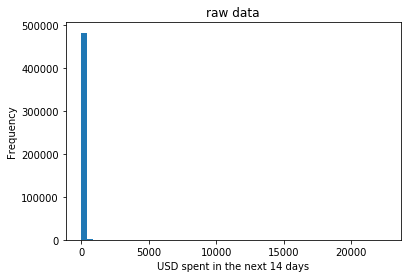

In [14]:
plt.hist(spend_usd_next_14_days, bins=50)
plt.xlabel("USD spent in the next 14 days")
plt.ylabel("Frequency")
plt.title("raw data")
plt.show()

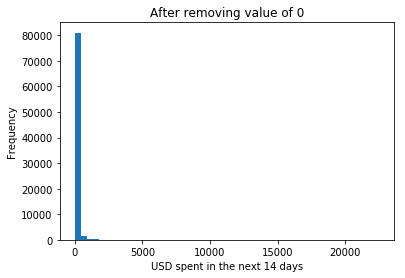

In [15]:
plt.hist(spend_usd_next_14_days[spend_usd_next_14_days!=0], bins=50)
plt.xlabel("USD spent in the next 14 days")
plt.ylabel("Frequency")
plt.title("After removing value of 0")
plt.show()

In [17]:
n = len(spend_usd_next_14_days)+0.0
print ('# users who spend larger than 100 USD: ', len(spend_usd_next_14_days[spend_usd_next_14_days>=100])/n)
print ('# users who spend larger than 500 USD: ', len(spend_usd_next_14_days[spend_usd_next_14_days>=500])/n)

# users who spend larger than 100 USD:  0.027572637538014314
# users who spend larger than 500 USD:  0.003749300619171396


The plots are highly skewed because of outliers. There are a few transactions that have extremely high spend. We calculate that among all user, percentage of users who spend larger that 200 USD is 2.7%, which is pretty much low. Thus we can roughly set 200 and see the distribution plot again. We can see the plot makes much more sense. Most of the spends are between 0~40, which is the reasonable price of an app.

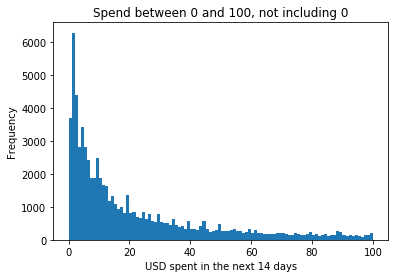

In [18]:
plt.hist(spend_usd_next_14_days[(spend_usd_next_14_days<=100) & (spend_usd_next_14_days!=0)], bins=100)
plt.xlabel("USD spent in the next 14 days")
plt.ylabel("Frequency")
plt.title("Spend between 0 and 100, not including 0")
plt.show()

We want to know the percentage of users who spend the money. Then, we may wonder, if users have already made purchase before May 1, will the percentage change a lot?

The answer would be yes, if you see the below two percentages.

In [20]:
# population percentage
popu_spend_rate = np.mean(spend_usd_next_14_days!=0)
# if people had purchased stuff before May 1
purchased = df[df['made_purchase_before']==1]
purchased_spend_rate = len(purchased[purchased['spend_usd_next_14_days']!=0]) / (len(purchased)+0.0)

print ('The population spend rate is: ', popu_spend_rate)
print ('If purchased before, the spend rate is: ', purchased_spend_rate)

The population spend rate is:  0.17169154156954478
If purchased before, the spend rate is:  0.7309907664530816


### Actual Purchase Funnel

Basically, the user will go through several steps until finishing purchase. 
* First, he enters the app store and sees the webpage. This stage we call it "Visited". Users can see lots of apps and choose one of them if he like. 
* Then he goes to the next stage, "Saw cart". Now there are some products he really loves and he adds the products into the cart.
* If he decides to buy the product, he will click the buy button. So in this step, we call it "Clicked". 
* The page then turns to the payment information. Users will choose the form of payment he usually uses, and finished the purchase. 

First, we see how many users are there in each steps. Then, they can be divided by whole population to calculate conversion rate for each stage. Thus we draw a funnel plot. 

Number of users and conversion rate for each stage: 
      action       num  cr_stage
0    visited  484357.0  0.854699
1        saw  451933.0  0.797483
2    clicked  124233.0  0.219222
3  purchased  101911.0  0.179833


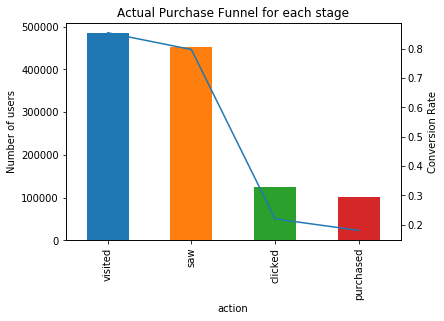

In [22]:
# for each stage
n_total = len(my_data)
n_visited = len(df)
n_saw = df['saw_cart_before'].sum()
n_clicked = df['clicked_buy_before'].sum()
n_purchased = df['made_purchase_before'].sum()

# create dataframe in convenience 
funnel_df = pd.DataFrame(columns=['action','num','cr_stage'])
funnel_df['action'] = ['visited','saw','clicked','purchased']
funnel_df['num'] = [n_visited, n_saw, n_clicked, n_purchased]
funnel_df['cr_stage'] = np.array([n_visited, n_saw, n_clicked, n_purchased]) / n_total

# show details table
print ('Number of users and conversion rate for each stage: ')
print (funnel_df)

# plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
funnel_df.plot.bar('action','num', ax = ax1, legend=False)
funnel_df.plot('action','cr_stage', ax = ax2, legend=False)
ax1.set_ylabel('Number of users')
ax2.set_ylabel('Conversion Rate')
ax1.set_title('Actual Purchase Funnel for each stage')
plt.show()

Second, from one stage to next, we can also calculate a conversion rate. we will get two plots to make comparson. 

         stage_stage  cr_from_to
0      begin_visited    0.854699
1        visited_saw    0.933058
2        saw_clicked    0.274893
3  clicked_purchased    0.820321


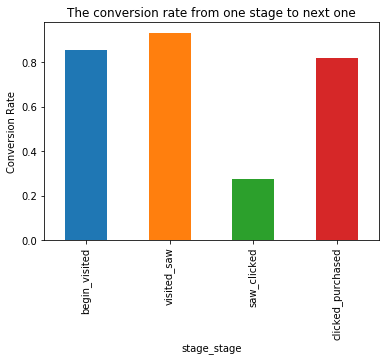

In [24]:
funnel_df['stage_stage'] = ['begin_visited','visited_saw','saw_clicked','clicked_purchased']
funnel_df['cr_from_to'] = [n_visited/(n_total+0.0), n_saw/n_visited, n_clicked/n_saw, n_purchased/n_clicked]
print (funnel_df[['stage_stage','cr_from_to']])

funnel_df.plot.bar('stage_stage', 'cr_from_to', legend=False)
plt.ylabel('Conversion Rate')
plt.title("The conversion rate from one stage to next one")
plt.show()

### Form of Payment

C:\Software\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Software\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Software\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Software\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


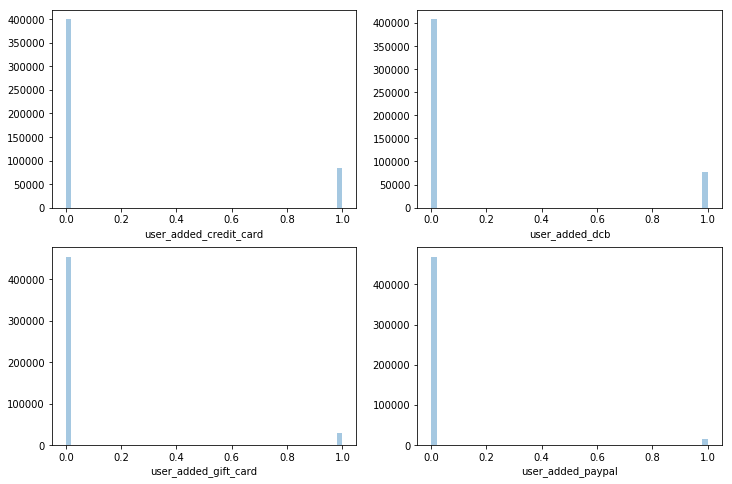

In [25]:
# show the distribution of FOP
target_features = ['user_added_credit_card','user_added_dcb'
                        ,'user_added_gift_card','user_added_paypal']
# categorical variables histogram
fig = plt.figure(figsize=(12,8))
for i,column in enumerate(target_features):
    fig.add_subplot(2,2,i+1)
    sns.distplot(df[column], kde=False)

We can see that people are more likely to use credit card and dcb. There are less people who are using gift card or paypal. 

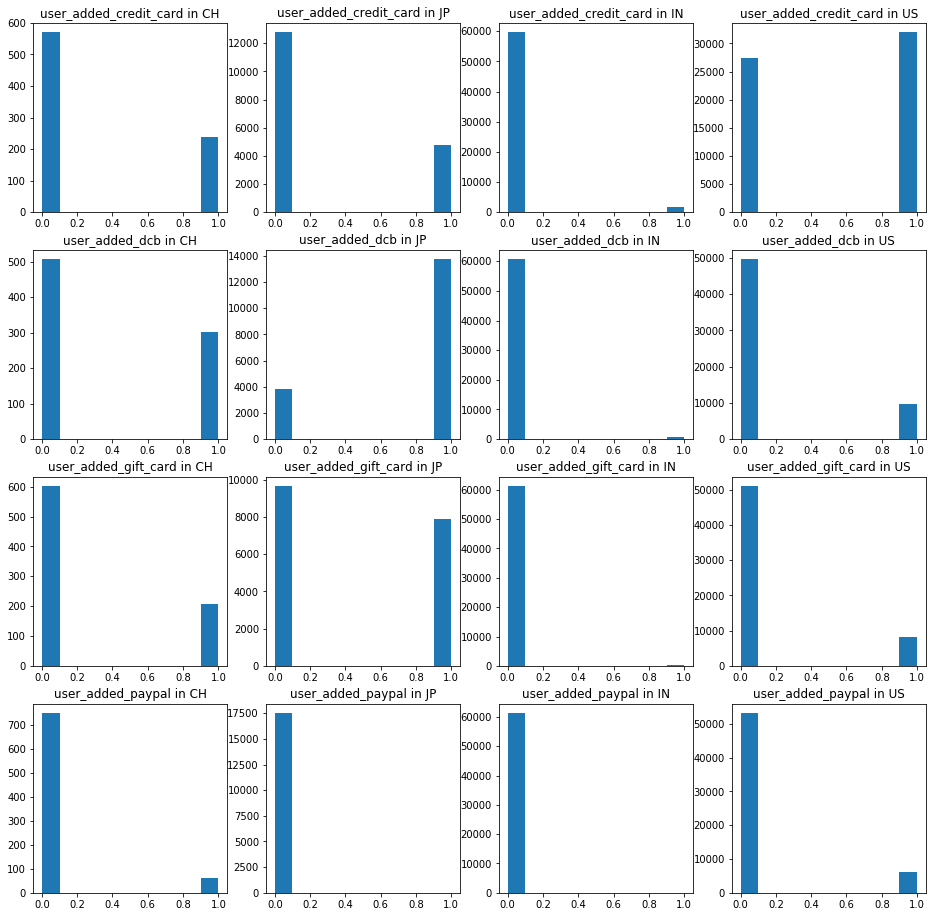

In [26]:
country = ['CH','JP','IN','US']
count = 1
fig = plt.figure(figsize=(16,16))
for i,fop in enumerate(target_features):
    for j,c in enumerate(country):
        fig.add_subplot(4,4,count)
        plt.hist(df[df['country']==c][fop])
        plt.title(fop + ' in ' + c)
        # plt.ylabel("frequency")
        count += 1

If we want to analysis the effect of FOP, we should focus on the stage between "clicked_buy_before" and "made_purchased_before". So the conversion rate should be:
$$ConversionRate = \frac{Number \ Of \ People \ With \ clicked\_buy\_before = 1}{Number \ Of \ People \ With \ made\_purchased\_before = 1} | \ obj = 1$$

However, we should notice that, some records may contain more than one FOP, which means that we may not know which form of payment is used in this transaction, if there are many. Thus, we proceed two approaches here. 
* Multiple FOP counts for all
* Remove those who have more than one FOP.

In [28]:
def cr_fop(stage_interval, obj, df):
    """
    stage_interval: The interval containing starting stage and ending stage
    obj: the object we want to calculate conversion rate for
    """
    tmp = df[df[obj]==1][stage_interval].sum()
    return tmp[1] / tmp[0]

stage_interval = ['clicked_buy_before','made_purchase_before']

# calculate multiple fop conversion rate
multiple_fop = []
for obj in target_features:
    cr = cr_fop(stage_interval, obj, df)
    multiple_fop.append(cr)

# calculate single fop conversion rate
df['user_added_sum'] = df['user_added_credit_card']+df['user_added_dcb'] + \
                       df['user_added_gift_card']+df['user_added_paypal']
single_fop_df = df[df['user_added_sum']==1]
single_fop = []
for obj in target_features:
    cr = cr_fop(stage_interval, obj, single_fop_df)
    single_fop.append(cr)

print ('The length of multiple_fop', len(df))
print ('The length of single_fop', len(single_fop_df))

The length of multiple_fop 484357
The length of single_fop 113094


In [29]:
# distribution 
single_fop_df[target_features].sum() 

user_added_credit_card    51320.0
user_added_dcb            47251.0
user_added_gift_card       9326.0
user_added_paypal          5197.0
dtype: float64

FOP conversion rate: 
                      fop  multiple_fop  single_fop
0  user_added_credit_card      0.863623    0.809564
1          user_added_dcb      0.814635    0.711575
2    user_added_gift_card      0.960136    0.953946
3       user_added_paypal      0.883465    0.784256


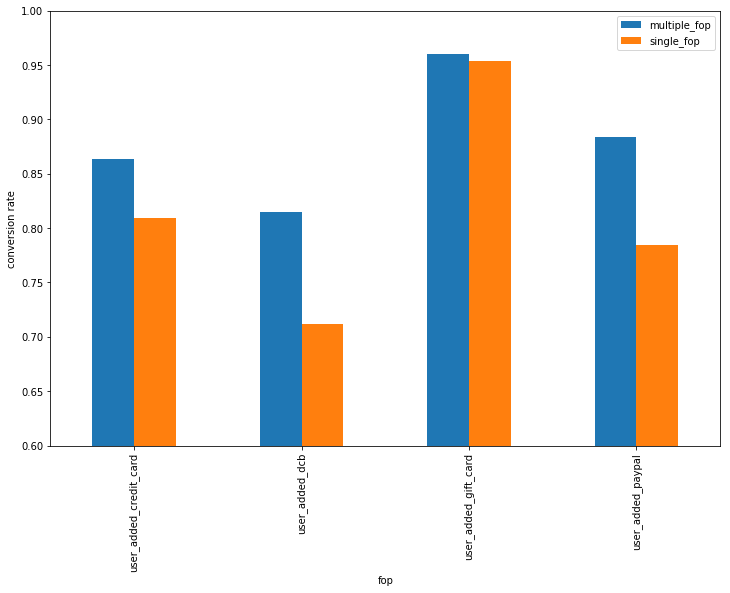

In [31]:
# draw bar plot 
res_fop_df = pd.DataFrame(columns=['fop','multiple_fop','single_fop'])
res_fop_df['fop'] = target_features
res_fop_df['multiple_fop'] = multiple_fop
res_fop_df['single_fop'] = single_fop
print ('FOP conversion rate: ')
print (res_fop_df)
res_fop_df.plot.bar(x='fop',y=['multiple_fop','single_fop'],figsize=(12,8))
plt.ylim(0.6,1.0)
plt.ylabel("conversion rate")
plt.show()

## Set Up Experiment

We can conclude:
* More than 40% users only have dcb payment, but the conversion rate is low
* Gift card has the highest conversion rate 
* For the single payment view, Credit Card has higher conversion rate than Paypal
* ...

Now we have several possible strategies. 
* Ask more from good: Credit card discount raises from 3% to 3.5%
* Fix things: Find those who only use paypal. See where they usually go. Then make ads for credit card.
* ...

Assume that we choose to "Fix things". Next step is to perform A/B test. Users, who only use Paypal as the FOP, are most likely to view 'GAMES', 'MOVIES' and 'MUSIC'. Totally, 49166 users are involved, with 24695 users in case group and 24471 users in control group. 

## A/B test

In [35]:
experiment = pd.read_csv("C:/Users/yangj/Desktop/App_store/Python_project_experiment.csv")
experiment.head()

,country,date,experiment_id,order_id,spend_usd,user_bucket,user_id,vertical
0,NaN,NaN,12624549,NaN,0.0,3,1.655440e+19,NaN
1,NaN,NaN,12624548,NaN,0.0,14,1.441150e+19,NaN
2,NaN,NaN,12624549,NaN,0.0,20,8.425200e+18,NaN
3,NaN,NaN,12624549,NaN,0.0,16,1.130270e+19,NaN
4,NaN,NaN,12624549,NaN,0.0,14,1.399240e+18,NaN


In [38]:
control = experiment[experiment['experiment_id']==12624549]['spend_usd']
case = experiment[experiment['experiment_id']==12624548]['spend_usd']

print ('Total number of experiment users is', len(experiment))
print ('Number of users in case group: ', len(case))
print ('Number of users in control group: ', len(control))

Total number of experiment users is 49166
Number of users in case group:  24695
Number of users in control group:  24471


In [0]:
print 'Statistical summary for case group:'
print case.describe()
print '========================================'
print 'Statistical summary for control group:'
print control.describe()

Statistical summary for case group:
count    24695.000000
mean         3.101232
std         11.647487
min          0.000000
25%          0.000000
50%          0.000000
75%          0.975661
max        119.990000
Name: spend_usd, dtype: float64
Statistical summary for control group:
count    24471.000000
mean         2.807225
std         10.974284
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        199.990000
Name: spend_usd, dtype: float64


In [39]:
# perform two sample one side t-test on case/control group
from scipy import stats
stats.ttest_ind(case, control, equal_var=True)

Ttest_indResult(statistic=2.8801076680362367, pvalue=0.003977110569393284)

Here, we got the pvalue less than 0.01, which means that we could reject the null hypothesis and conclude that case and control group have different mean. Actually, we got a positive statistic. Thus **statistically, our action policy will bring the increase of the revenue for the app store.** And we can recommend to our VP that we should focus more on those who only use paypal as FOP, showing them the benefit of the credit card and offering them possible discount. 